In [ ]:
'''Setup:

Agent Based Model for PA in group based social networks

Agents are users
  users have two parameters : post rate & comment rate
    poisson random variables

Forums create threads where users interact
  
create interaction matrix between users, records number of interactions over given interval

measurements are number of interactions between agents for a given time interval

at each time step:
  initialize random number of new users
  each new user joins random number of groups (not based on group size)
  for each user:
    random number of posts based on user post rate, placed in user groups based on group size
    gather list of all posts in every group user is part of 
      add comments based on comment rate, proportional to most active threads (highest number of existing comments)
        for each comment choose a random user in the thread that this user 'replied' to, add to interaction matrix
'''

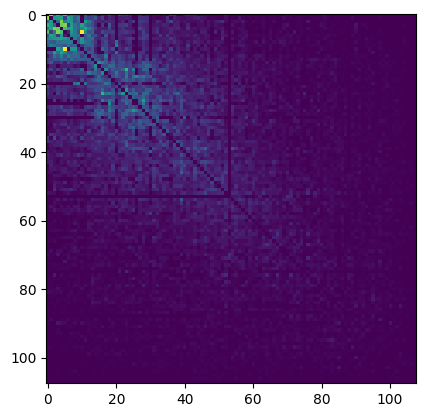

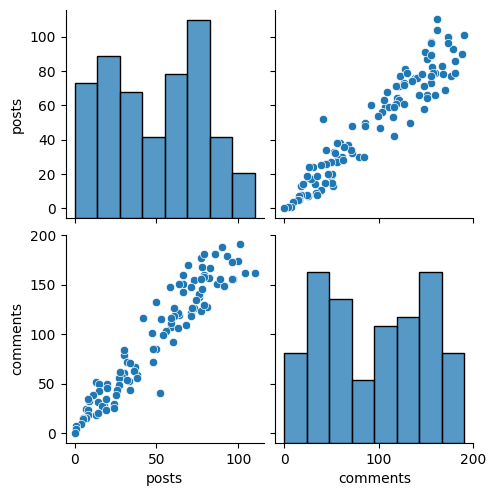

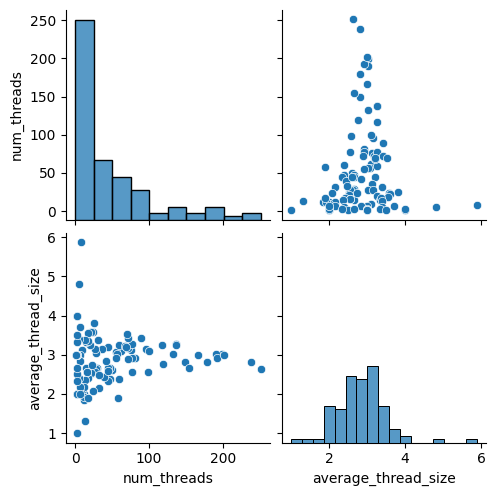

In [86]:
import numpy as np

class User:
    def __init__(self, post_rate, comment_rate, user_id) -> None:
        self.id = user_id
        self.post_rate = post_rate
        self.comment_rate = comment_rate
        self.groups = []
        self.num_posts = 0
        self.num_comments = 0

class Group:
    def __init__(self, group_id) -> None:
        self.id = group_id
        self.users = []
        self.threads = []

class Thread:
    def __init__(self, post_user) -> None:
        self.post_user = post_user
        self.comments = []

    def add_comment(self, comment_user):
        self.comments.append(comment_user)

    def get_other_users(self, user_id):
        return [u for u in [self.post_user] + self.comments if u.id != user_id]

class Simulation:
    def __init__(self, group_creation_rate) -> None:
        self.users = []
        self.groups = []
        self.group_creation_rate = group_creation_rate
        self.interaction_matrix = None
        self.next_group_id = 0

    def add_user(self, post_rate, comment_rate):
        user_id = len(self.users)
        new_user = User(post_rate, comment_rate, user_id)
        self.users.append(new_user)
        return new_user

    def add_group(self):
        group_id = self.next_group_id
        new_group = Group(group_id)
        self.groups.append(new_group)
        self.next_group_id += 1
        return new_group

    def update_interaction_matrix(self, new_size):
        new_matrix = np.zeros((new_size, new_size))
        if self.interaction_matrix is not None:
            new_matrix[:self.interaction_matrix.shape[0], :self.interaction_matrix.shape[1]] = self.interaction_matrix
        self.interaction_matrix = new_matrix

    def initialize_user(self, post_rate, comment_rate):
        # Initialize a single new user
        new_user = self.add_user(post_rate, comment_rate)

        # Determine number of new groups to create
        num_new_groups = np.random.poisson(self.group_creation_rate)
        for _ in range(num_new_groups):
            new_user.groups.append(self.add_group())

        # Update the interaction matrix with the new user
        self.update_interaction_matrix(len(self.users))

        return new_user

    def initialize(self, num_users, post_rate, comment_rate) -> None:
        # Initialize users and groups
        for _ in range(num_users):
            self.initialize_user(post_rate, comment_rate)

    def simulate_time_step(self, post_rate, comment_rate, avg_num_new_users):
        # Initialize new users
        for _ in range(np.random.poisson(avg_num_new_users)):
            new_user = self.initialize_user(post_rate, comment_rate)
            # Assign new user to existing groups randomly
            if self.groups:
                num_groups_to_join = np.random.randint(1, len(self.groups) + 1)
                groups_to_join = np.random.choice(self.groups, num_groups_to_join, replace=False)
                for group in groups_to_join:
                    new_user.groups.append(group)
                    group.users.append(new_user)

        # Existing and new users post and comment
        for user in self.users:
            # Posting in groups
            for _ in range(np.random.poisson(user.post_rate)):
                if user.groups:
                    group = np.random.choice(user.groups)
                    thread = Thread(user)
                    group.threads.append(thread)
                    user.num_posts += 1
            # Commenting in group threads
            for _ in range(np.random.poisson(user.comment_rate)):
                participating_groups = [group for group in user.groups if group.threads]
                if participating_groups:
                    group = np.random.choice(participating_groups)
                    thread = np.random.choice(group.threads)
                    other_users = thread.get_other_users(user.id)
                    if other_users:
                        thread.add_comment(user)
                        # Interaction: User comments on a thread, we add interaction for all other users in this thread
                        for thread_user in other_users:
                            self.interaction_matrix[user.id][thread_user.id] += 1
                            self.interaction_matrix[thread_user.id][user.id] += 1
                        user.num_comments += 1
                        
    def run_simulation(self, num_steps, post_rate, comment_rate, avg_num_new_users):
        for _ in range(num_steps):
            self.simulate_time_step(post_rate, comment_rate, avg_num_new_users)

# Parameters for simulation
num_initial_users = 1
post_rate = 2  # Average post rate for Poisson distribution
comment_rate = 4  # Average comment rate for Poisson distribution
group_creation_rate = 1  # Average rate of group creation for Poisson distribution
avg_num_new_users = 2  # Average number of new users per timestep
num_steps = 50  # Number of time steps to simulate

# Create and run the simulation
simulation = Simulation(group_creation_rate)
simulation.initialize(num_initial_users, post_rate, comment_rate)
simulation.run_simulation(num_steps, post_rate, comment_rate, avg_num_new_users)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

plt.imshow(simulation.interaction_matrix)

post_counts = [user.num_posts for user in simulation.users]
comment_counts = [user.num_comments for user in simulation.users]
sns.pairplot(pd.DataFrame({'posts': post_counts, 'comments': comment_counts}))

thread_counts = [len(group.threads) for group in simulation.groups]
thread_user_counts = [np.mean([len(thread.comments) + 1 for thread in group.threads]) for group in simulation.groups]
sns.pairplot(pd.DataFrame({'num_threads': thread_counts, 'average_thread_size': thread_user_counts}))